# Sun

In [37]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os
from astropy.io import ascii
import astropy.constants


##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk


import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

## Import pitchfork

In [38]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


## save observed/published parameters

In [39]:
#parameters for star, [value,unc], NaN for not found/published
#1 : Lyttle
#2 : Asplund 2020
#3 : 
#4 : 

star_name = 'Sun'

star_dict={}

star_dict['initial_mass']=[1, 0.001] #1
star_dict['initial_Zinit']= [0.0154, 0.002] #2
star_dict['initial_Yinit']= [0.2766, 0.01] #2
star_dict['initial_MLT']= [1.92, 0.09] #2
star_dict['star_age']=[4.6, 0.1] #1

star_dict['calc_effective_T']=[5777, 20]  #1
star_dict['radius']=[1, 0.001] #1
star_dict['luminosity']=[1, 0.01] #1
star_dict['star_feh']=[0, 0.01] #1

#############
star_dict['nu_0_6']= [972.615, 0.002]
star_dict['nu_0_7']= [1117.993, 0.004]
star_dict['nu_0_8']= [1263.198, 0.005]
star_dict['nu_0_9']= [1407.472, 0.006]
star_dict['nu_0_10']= [1548.336, 0.007]
star_dict['nu_0_11']= [1686.594, 0.012]
star_dict['nu_0_12']= [1822.202, 0.012]
star_dict['nu_0_13']= [1957.452, 0.012]
star_dict['nu_0_14']= [2093.518, 0.013]
star_dict['nu_0_15']= [2228.749, 0.014]
star_dict['nu_0_16']= [2362.788, 0.016]
star_dict['nu_0_17']= [2496.180, 0.017]
star_dict['nu_0_18']= [2629.668, 0.015]
star_dict['nu_0_19']= [2764.142, 0.015]
star_dict['nu_0_20']= [2899.022, 0.013]
star_dict['nu_0_21']= [3033.754, 0.014]
star_dict['nu_0_22']= [3168.618, 0.017]
star_dict['nu_0_23']= [3303.520, 0.021]
star_dict['nu_0_24']= [3438.992, 0.030]
star_dict['nu_0_25']= [3574.893, 0.048]
star_dict['nu_0_26']= [3710.717, 0.088]
star_dict['nu_0_27']= [3846.993, 0.177]
star_dict['nu_0_28']= [3984.214, 0.323]
star_dict['nu_0_29']= [np.nan, np.nan]
star_dict['nu_0_30']= [np.nan, np.nan]
star_dict['nu_0_31']= [np.nan, np.nan]
star_dict['nu_0_32']= [np.nan, np.nan]
star_dict['nu_0_33']= [np.nan, np.nan]
star_dict['nu_0_34']= [np.nan, np.nan]
star_dict['nu_0_35']= [np.nan, np.nan]
star_dict['nu_0_36']= [np.nan, np.nan]
star_dict['nu_0_37']= [np.nan, np.nan]
star_dict['nu_0_38']= [np.nan, np.nan]
star_dict['nu_0_39']= [np.nan, np.nan]
star_dict['nu_0_40']= [np.nan, np.nan]

##############

star_dict['dnu'] = [135.1, 0.2] #1
star_dict['nu_max'] = [3141, 12]

with open(f'stars/{star_name}/{star_name}.json', 'w') as fp:
    json.dump(star_dict, fp)

star_dict

{'initial_mass': [1, 0.001],
 'initial_Zinit': [0.0154, 0.002],
 'initial_Yinit': [0.2766, 0.01],
 'initial_MLT': [1.92, 0.09],
 'star_age': [4.6, 0.1],
 'calc_effective_T': [5777, 20],
 'radius': [1, 0.001],
 'luminosity': [1, 0.01],
 'star_feh': [0, 0.01],
 'nu_0_6': [972.615, 0.002],
 'nu_0_7': [1117.993, 0.004],
 'nu_0_8': [1263.198, 0.005],
 'nu_0_9': [1407.472, 0.006],
 'nu_0_10': [1548.336, 0.007],
 'nu_0_11': [1686.594, 0.012],
 'nu_0_12': [1822.202, 0.012],
 'nu_0_13': [1957.452, 0.012],
 'nu_0_14': [2093.518, 0.013],
 'nu_0_15': [2228.749, 0.014],
 'nu_0_16': [2362.788, 0.016],
 'nu_0_17': [2496.18, 0.017],
 'nu_0_18': [2629.668, 0.015],
 'nu_0_19': [2764.142, 0.015],
 'nu_0_20': [2899.022, 0.013],
 'nu_0_21': [3033.754, 0.014],
 'nu_0_22': [3168.618, 0.017],
 'nu_0_23': [3303.52, 0.021],
 'nu_0_24': [3438.992, 0.03],
 'nu_0_25': [3574.893, 0.048],
 'nu_0_26': [3710.717, 0.088],
 'nu_0_27': [3846.993, 0.177],
 'nu_0_28': [3984.214, 0.323],
 'nu_0_29': [nan, nan],
 'nu_0_30': 

## define priors

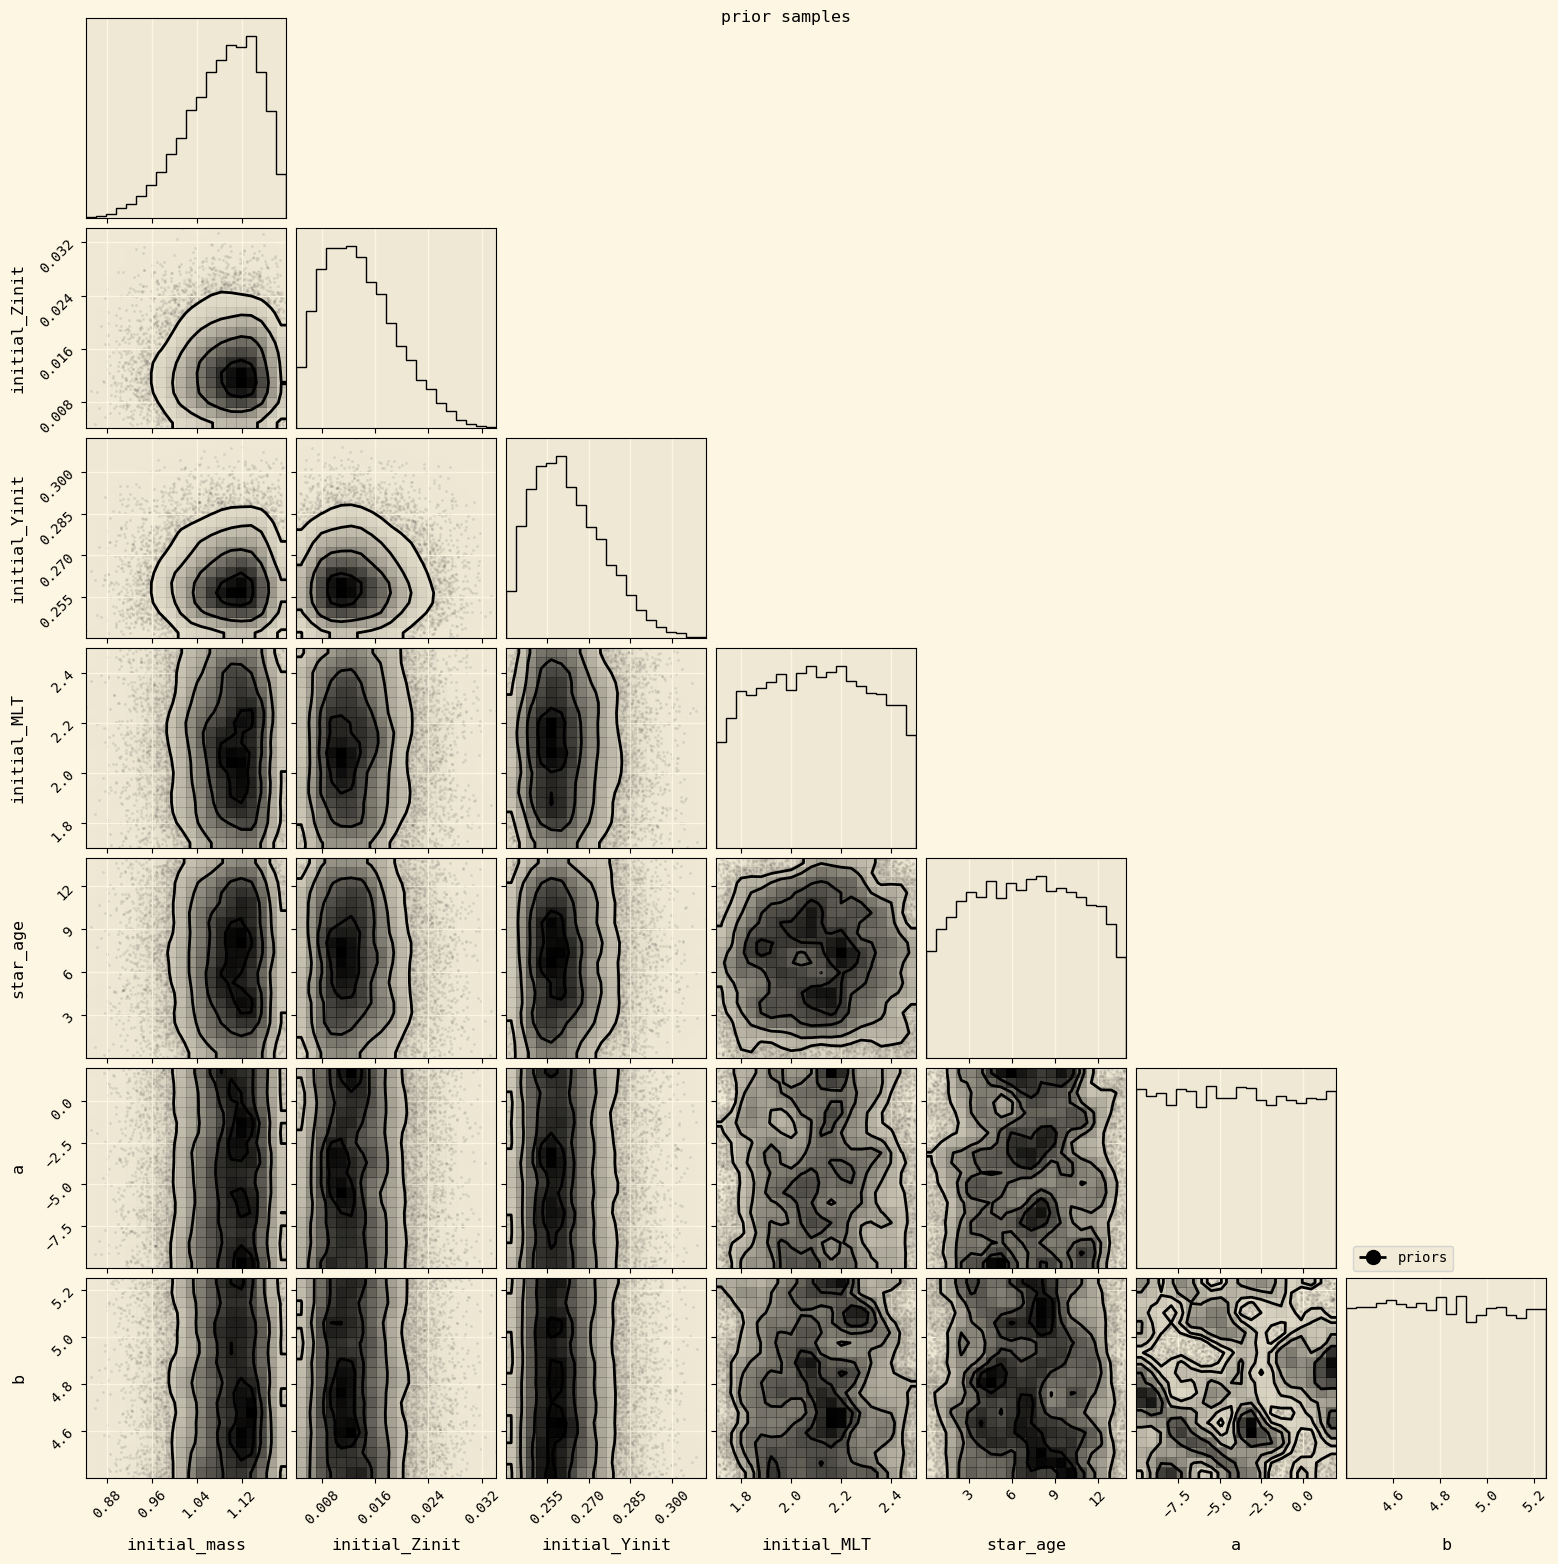

In [40]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

## pre-sampling step
define relevant covariance matrices for likelihood, inputs and outputs etc

In [41]:
path = f'stars/{star_name}/'

star_json = path + f'{star_name}.json'

star_df = pd.read_json(star_json).dropna(axis=1)

star_vals_df = star_df.iloc[[0]]

star_uncs_df = star_df.iloc[[1]]

star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

nu_max = star_df["nu_max"].values[0]

### obs matrix
star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))

### nn matrix
with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

### gp matrix
obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()

dnu = star_df['dnu'].values[0]

kernel = .1*kernels.ExpSquared(scale=5*dnu) ################################## Changed from 1 to .1, change back!!

gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)

gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()

gp_cov_padded = np.pad(gp_cov, (3,0))

# add covariance matrices
sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

In [ ]:
%%time

import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

    
ndraw_min=2**16
ndraw_max=2**21

print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = ultra_ns_vector_surface(priors=priors, observed_vals=star_obs_vals_df.values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=.1, max_ncalls=5e6)
with open(path+'/samples.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

sampler.cleanup()
del results

|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|              1 |          0.0154 |          0.2766 |          1.92 |        4.6 |


/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


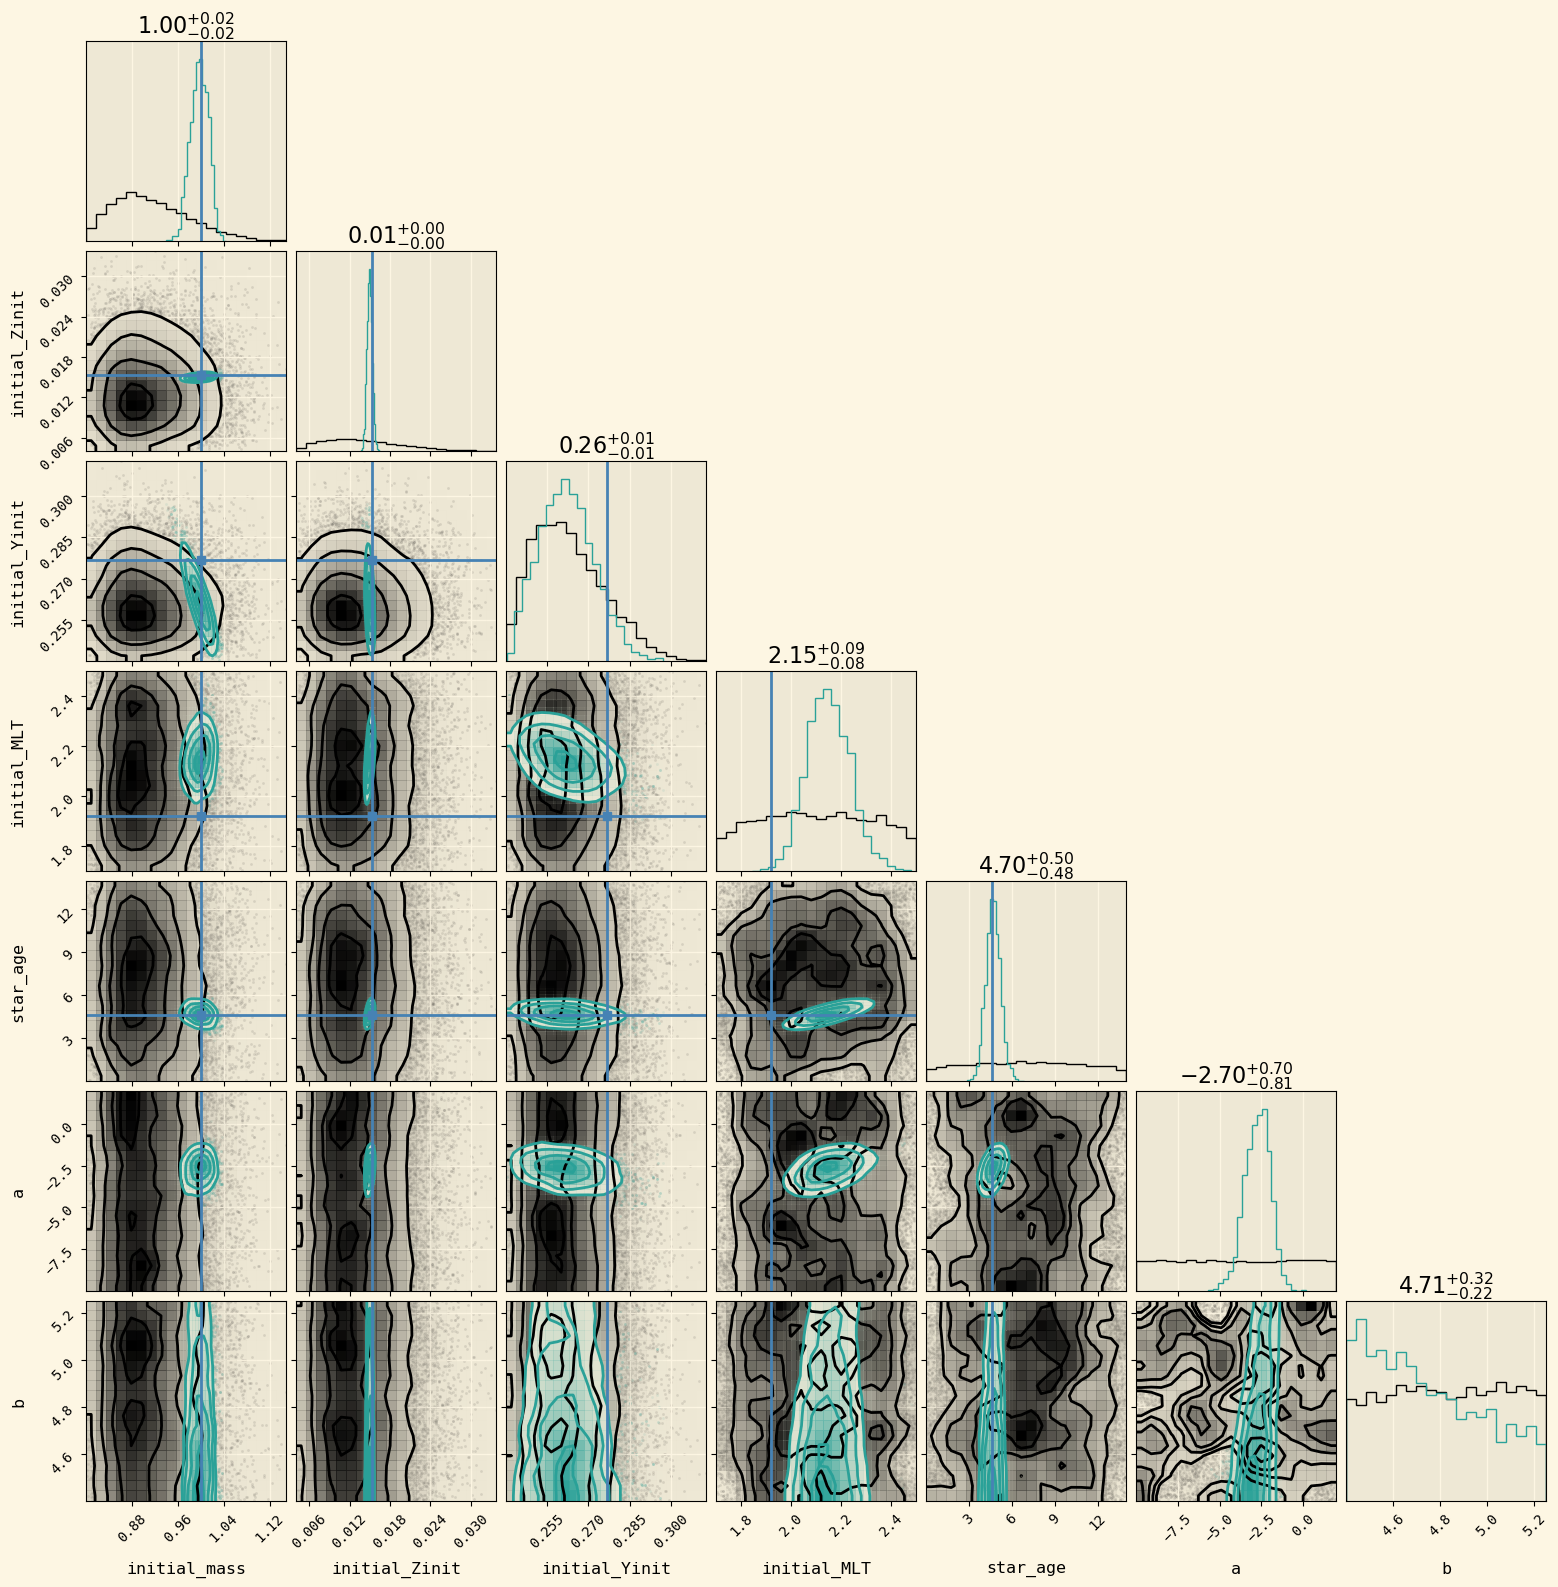

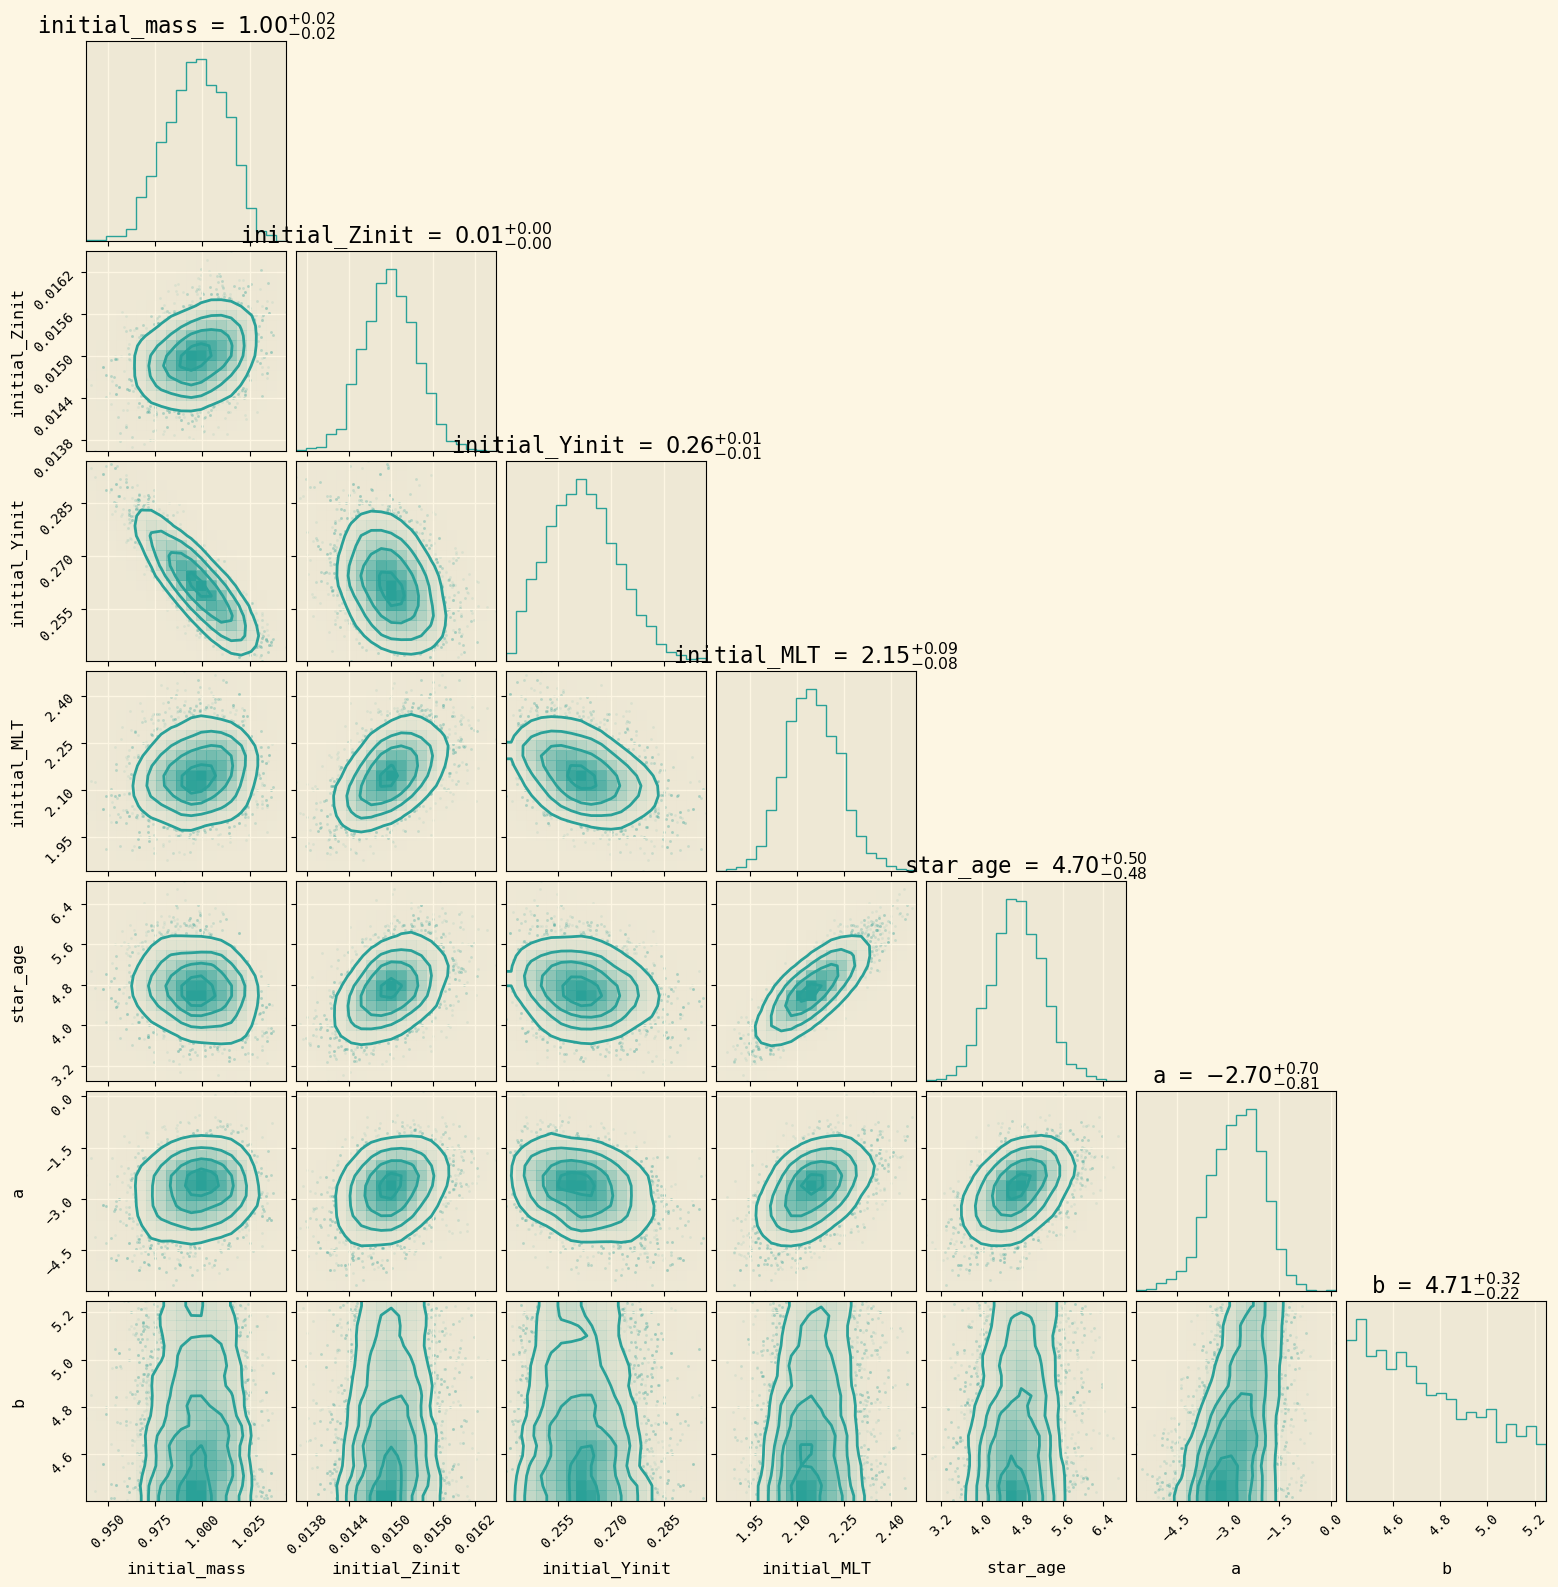

In [10]:
def inspect_star(path):

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    
    path = f'stars/{star_name}/'
    
    star_json = path + f'{star_name}.json'Performance
    
    star_df = pd.read_json(star_json).dropna(axis=1)

    published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

    with open(path+f'/samples.pkl', 'rb') as fp:
     samples = pickle.load(fp)
        
    corner.corner(samples['samples'], fig=figure, color=colors[1], truths = published_inps, hist_kwargs={'density':True}, smooth=True,show_titles=True);

    plt.show()

    figure = corner.corner(samples['samples'], labels = labels, color=colors[1], hist_kwargs={'density':True}, smooth=True, show_titles=True);

    plt.show()
    
inspect_star(path)

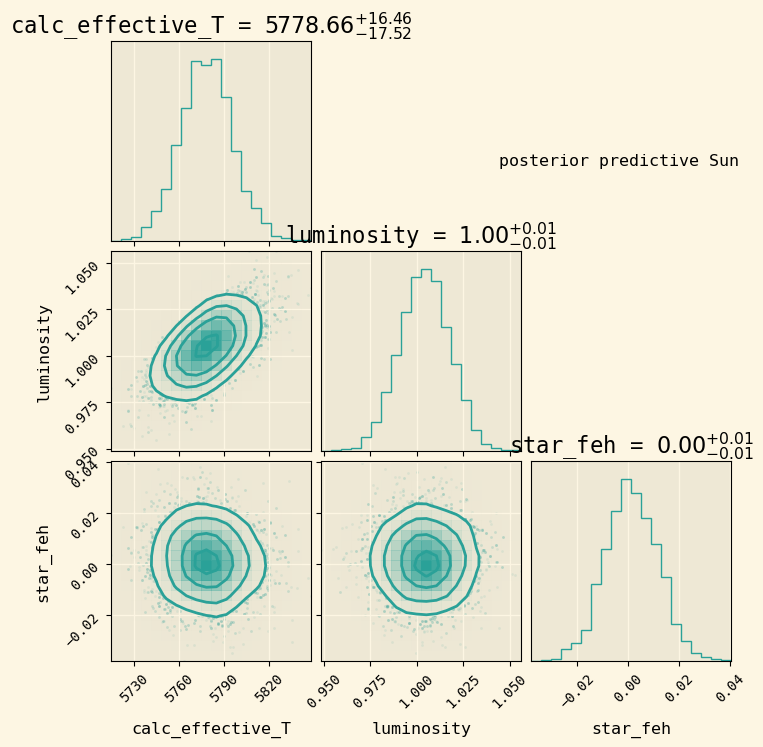

nu_0_6      972.488534
nu_0_7     1118.413000
nu_0_8     1263.039778
nu_0_9     1407.210125
nu_0_10    1548.463093
nu_0_11    1685.855550
nu_0_12    1821.356142
nu_0_13    1956.986261
nu_0_14    2092.774626
nu_0_15    2227.823933
nu_0_16    2361.957155
nu_0_17    2495.836243
nu_0_18    2630.182204
nu_0_19    2765.165036
nu_0_20    2900.498972
nu_0_21    3035.996396
nu_0_22    3171.723233
nu_0_23    3307.733029
nu_0_24    3444.186635
nu_0_25    3581.214410
nu_0_26    3718.502919
nu_0_27    3855.543460
dtype: float64
[972.615]
[1117.993]
[1263.198]
[1407.472]
[1548.336]
[1686.594]
[1822.202]
[1957.452]
[2093.518]
[2228.749]
[2362.788]
[2496.18]
[2629.668]
[2764.142]
[2899.022]
[3033.754]
[3168.618]
[3303.52]
[3438.992]
[3574.893]
[3710.717]
[3846.993]


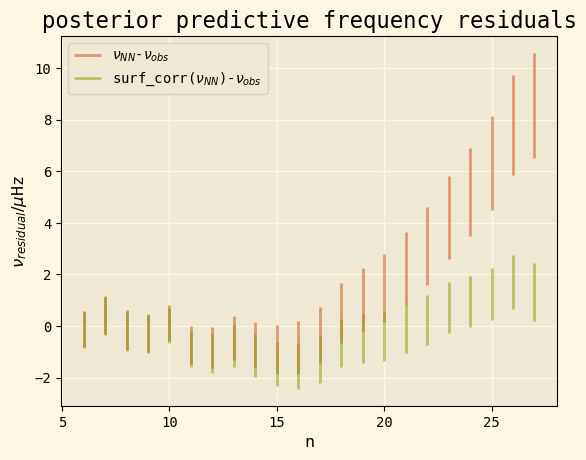

In [11]:
def posterior_pred(pitchfork, star_name):

    path = f'stars/{star_name}/'

    with open(path+f'/samples.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)


    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "star_feh"]], labels = ["calc_effective_T", "luminosity", "star_feh"], color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)
    plt.show()

    ### freqs posterior preds

    n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
    n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
    pred_freqs = preds_df[[f"nu_0_{i}" for i in range(n_min, n_max)]]
    print(np.mean(pred_freqs, axis=0))
    

    ## corrected freq posterior pred
    def surf_corr(freqs, nu_max, a, b):
        return freqs + a * ((freqs / nu_max) ** b)

    a_samples = samples_df['a'].values
    b_samples = samples_df['b'].values
    
    for n in range(n_min, n_max):
        n_samples = pred_freqs[f"nu_0_{n}"].values
        observed_freqs = star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1)[f"nu_0_{n}"].values
        print(observed_freqs)

        n_samples_residual = n_samples - np.full(len(n_samples),observed_freqs)

        ### keep for lines
        n_samples_residual_mu = n_samples_residual.mean()
        n_samples_residual_std = n_samples_residual.std()

        plot_upper = n_samples_residual_mu + n_samples_residual_std
        plot_lower = n_samples_residual_mu - n_samples_residual_std
        if n == n_min:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[4], label=r'$\nu_{NN}$-$\nu_{obs}$',alpha=.5)
        else:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[4],alpha=.5)


        
        n_samples_corr = surf_corr(n_samples, nu_max, a_samples, b_samples)
        
        n_samples_residual = n_samples_corr - np.full(len(n_samples_corr),observed_freqs)

        ### keep for lines
        n_samples_residual_mu = n_samples_residual.mean()
        n_samples_residual_std = n_samples_residual.std()

        plot_upper = n_samples_residual_mu + n_samples_residual_std
        plot_lower = n_samples_residual_mu - n_samples_residual_std

        if n == n_min:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[2], label=r'surf_corr($\nu_{NN}$)-$\nu_{obs}$',alpha=.5)
        else:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[2],alpha=.5)
        ###

        ### keep for points
        #plt.scatter(np.full(len(n_samples_residual), n), n_samples_residual,c=colors[2], alpha=0.002)
    
        ###

    plt.legend()
    plt.xlabel('n')
    plt.ylabel(r'$\nu_{residual}/\mu$Hz')
    plt.title('posterior predictive frequency residuals')
    plt.show()


posterior_pred(pitchfork, star_name)

0       0.994307
1       0.992692
2       0.999241
3       0.997712
4       0.998554
          ...   
7898    1.010088
7899    0.998942
7900    0.996472
7901    1.002103
7902    1.002948
Name: radius, Length: 7903, dtype: float64


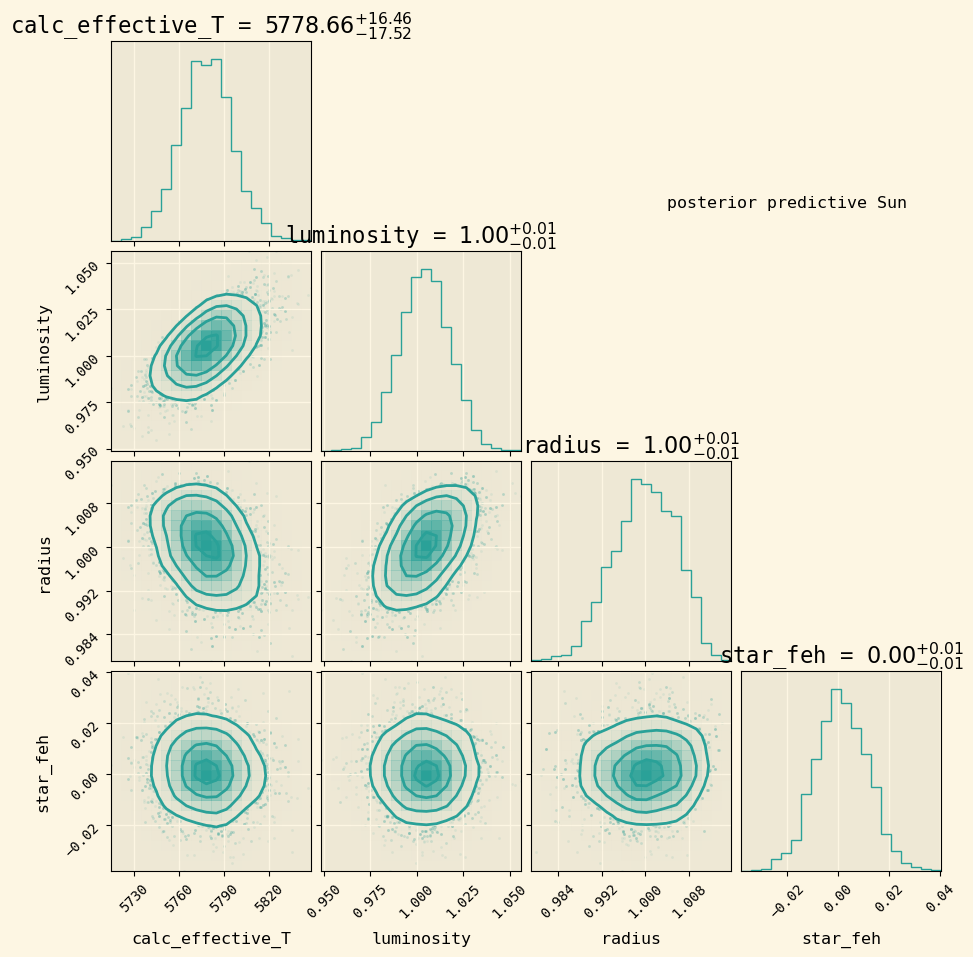

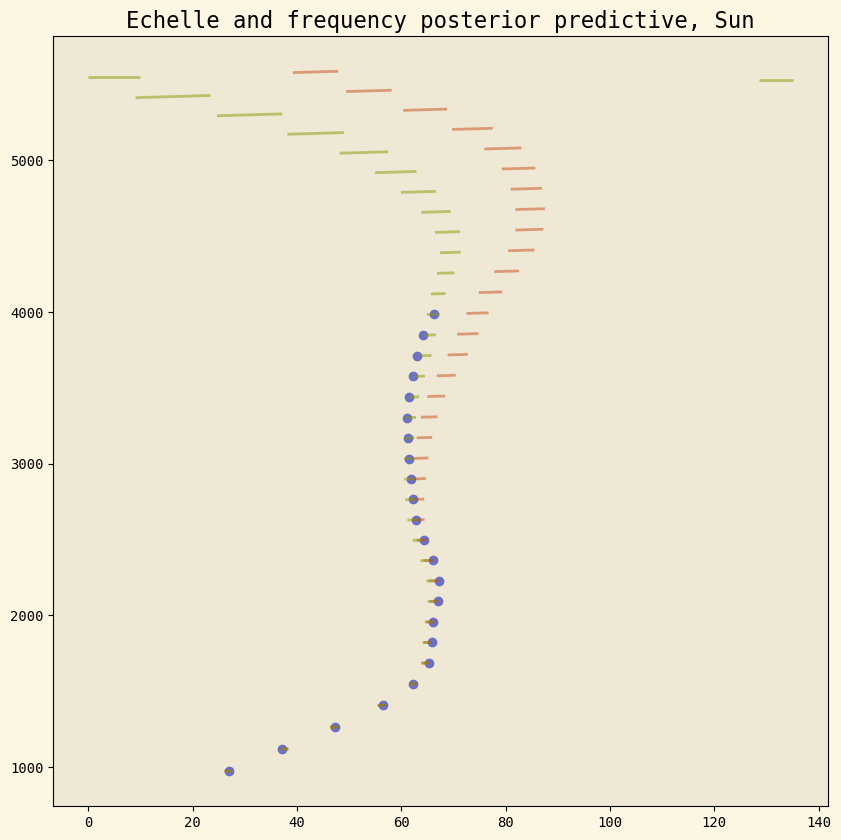

In [22]:
def posterior_pred(pitchfork, star_name):

    path = f'stars/{star_name}/'

    with open(path+f'/samples.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)

    preds_df['radius'] = (np.sqrt((preds_df['luminosity']*astropy.constants.L_sun)/(4*np.pi*constants.sigma*(preds_df['calc_effective_T']**4))))/astropy.constants.R_sun

    print(preds_df['radius'])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "radius", "star_feh"]], labels = ["calc_effective_T", "luminosity", "radius", "star_feh"], color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)
    plt.show()

    ### freqs posterior preds

    n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
    n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
    #print(len(pred_freqs))
    

    ## corrected freq posterior pred
    def surf_corr(freqs, nu_max, a, b):
        return freqs + a * ((freqs / nu_max) ** b)

    a_samples = samples_df['a'].values
    b_samples = samples_df['b'].values
    
    from echelle import plot_echelle

    # spectrum = np.loadtxt(f'stars/{star_name}/power.pow')
    # freq = spectrum[:,0]
    # power = spectrum[:,1]
    
    fig, ax = plt.subplots(figsize=[10, 10])
    #plot_echelle(freq,power,dnu, scale = 'sqrt', fmin=600, fmax=5000, interpolation='bicubic', smooth=True, ax=ax)

    echelle_c = colors[4]
    echelle_a = 0.5
    
    pred_freqs_array = preds_df[[f"nu_0_{i}" for i in range(6, 41)]]
    for n in range(6,41):
        pred_freqs = pred_freqs_array[f'nu_0_{n}'].values
        pred_freqs_mean = np.mean(pred_freqs)
        pred_freqs_std = np.std(pred_freqs)
        
        plot_lower_y = pred_freqs_mean - pred_freqs_std
        plot_lower_x = plot_lower_y%dnu

        plot_upper_y = pred_freqs_mean + pred_freqs_std
        plot_upper_x = plot_upper_y%dnu

        if plot_lower_x < plot_upper_x:
            ax.plot([plot_lower_x, plot_upper_x], [plot_lower_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
        else:
            ax.plot([0, plot_upper_x], [plot_upper_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
            ax.plot([plot_lower_x, dnu], [plot_lower_y, plot_lower_y], color=echelle_c, alpha=echelle_a)

    
    corrected_array = surf_corr(pred_freqs_array, nu_max, np.tile(a_samples,(35,1)).T,np.tile(b_samples,(35,1)).T)
    echelle_c = colors[2]
    echelle_a = 0.5
    for n in range(6,41):
        corrected_freqs = corrected_array[f'nu_0_{n}'].values
        corrected_freqs_mean = np.mean(corrected_freqs)
        corrected_freqs_std = np.std(corrected_freqs)
        
        plot_lower_y = corrected_freqs_mean - corrected_freqs_std
        plot_lower_x = plot_lower_y%dnu

        plot_upper_y = corrected_freqs_mean + corrected_freqs_std
        plot_upper_x = plot_upper_y%dnu

        if plot_lower_x < plot_upper_x:
            ax.plot([plot_lower_x, plot_upper_x], [plot_lower_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
        else:
            ax.plot([0, plot_upper_x], [plot_upper_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
            ax.plot([plot_lower_x, dnu], [plot_lower_y, plot_lower_y], color=echelle_c, alpha=echelle_a)

    obs_freqs = star_vals_df[[f'nu_0_{n}' for n in range(n_min, n_max+1)]].values
    ax.scatter(obs_freqs%dnu, obs_freqs, color= colors[7])

    plt.title(f'Echelle and frequency posterior predictive, {star_name}')
    plt.grid(visible=None)
    #plt.xlim(xmin=0, xmax=0)

posterior_pred(pitchfork, star_name)

0       0.994307
1       0.992692
2       0.999241
3       0.997712
4       0.998554
          ...   
7898    1.010088
7899    0.998942
7900    0.996472
7901    1.002103
7902    1.002948
Name: radius, Length: 7903, dtype: float64


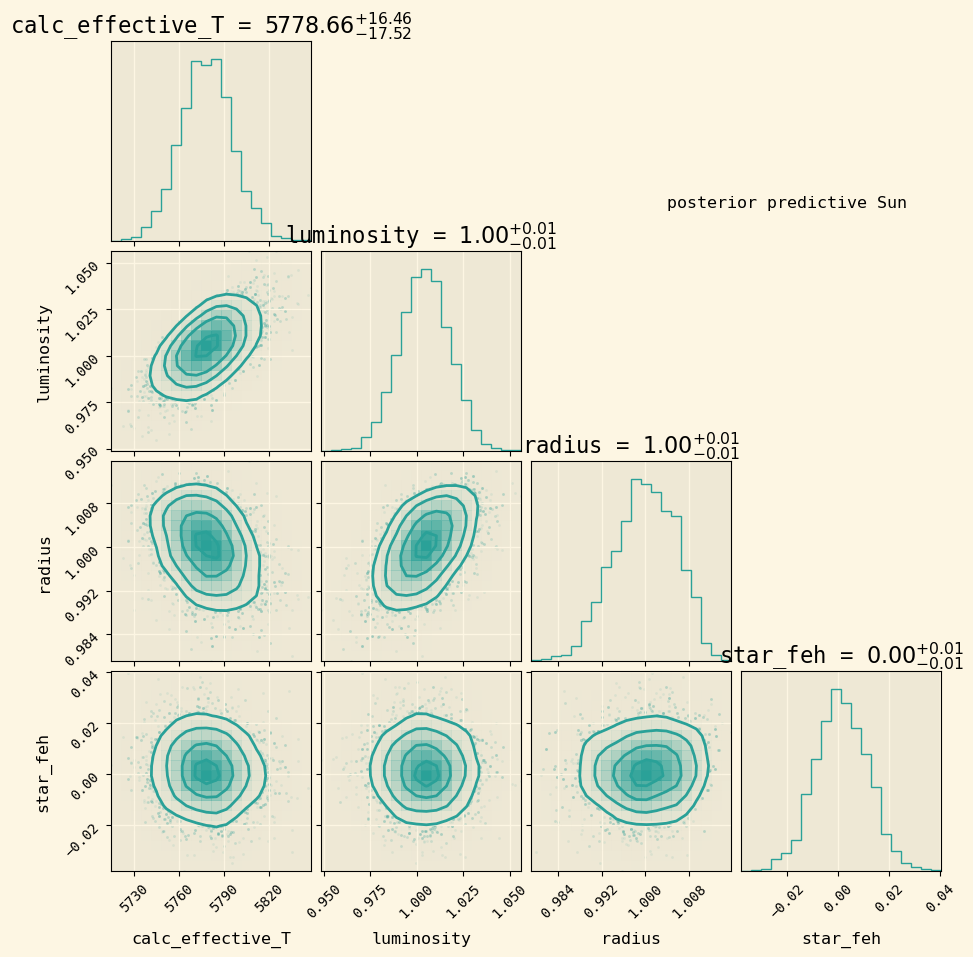

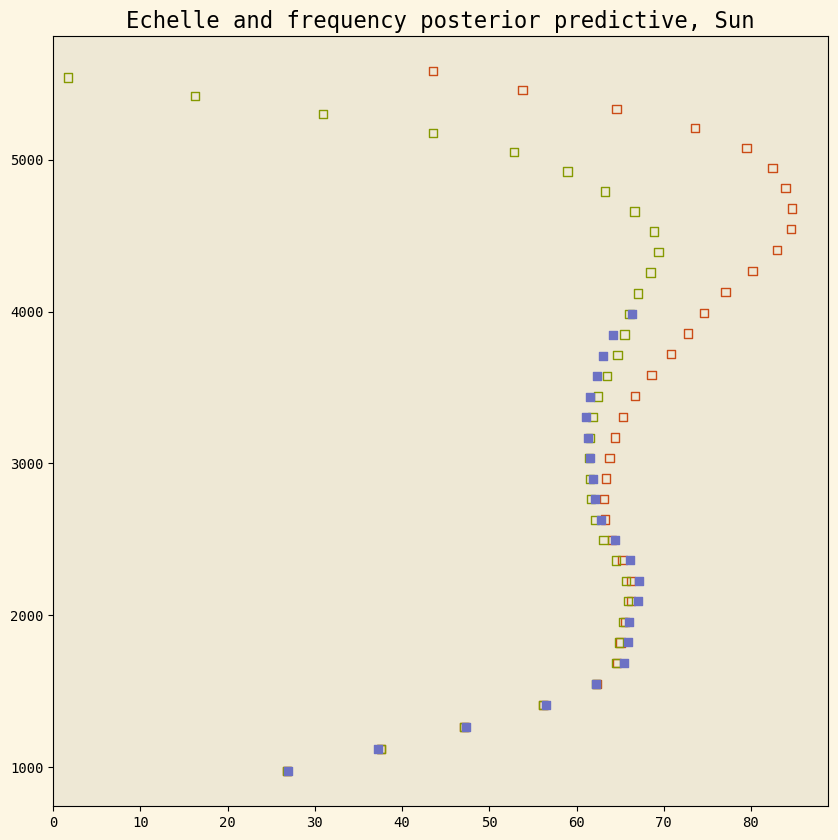

In [24]:
def posterior_pred(pitchfork, star_name):

    path = f'stars/{star_name}/'

    with open(path+f'/samples.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)

    preds_df['radius'] = (np.sqrt((preds_df['luminosity']*astropy.constants.L_sun)/(4*np.pi*constants.sigma*(preds_df['calc_effective_T']**4))))/astropy.constants.R_sun

    print(preds_df['radius'])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "radius", "star_feh"]], labels = ["calc_effective_T", "luminosity", "radius", "star_feh"], color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)
    plt.show()

    ### freqs posterior preds

    n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
    n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
    #print(len(pred_freqs))
    

    ## corrected freq posterior pred
    def surf_corr(freqs, nu_max, a, b):
        return freqs + a * ((freqs / nu_max) ** b)

    a_samples = samples_df['a'].values
    b_samples = samples_df['b'].values
    
    # from echelle import plot_echelle

    # spectrum = np.loadtxt(f'stars/{star_name}/power.pow')
    # freq = spectrum[:,0]
    # power = spectrum[:,1]
    
    fig, ax = plt.subplots(figsize=[10, 10])
    # plot_echelle(freq,power,dnu, scale = 'sqrt', fmin=600, fmax=5000, interpolation='bicubic', smooth=True, ax=ax, cmap="Blues")

    echelle_c = colors[4]
    echelle_a = 0.3
    
    pred_freqs_array = preds_df[[f"nu_0_{i}" for i in range(6, 41)]]
    for n in range(6,41):
        pred_freqs = pred_freqs_array[f'nu_0_{n}'].values
        pred_freqs_mean = np.mean(pred_freqs)
        ax.scatter(pred_freqs_mean%dnu, pred_freqs_mean, color=echelle_c, marker = 's', facecolors='none')
    
    corrected_array = surf_corr(pred_freqs_array, nu_max, np.tile(a_samples,(35,1)).T,np.tile(b_samples,(35,1)).T)
    echelle_c = colors[2]
    echelle_a = 0.3
    for n in range(6,41):
        corrected_freqs = corrected_array[f'nu_0_{n}'].values
        corrected_freqs_mean = np.mean(corrected_freqs)
        ax.scatter(corrected_freqs_mean%dnu, corrected_freqs_mean, color=echelle_c, marker = 's', facecolors='none')

    obs_freqs = star_vals_df[[f'nu_0_{n}' for n in range(n_min, n_max+1)]].values
    ax.scatter(obs_freqs%dnu, obs_freqs, color= colors[7], marker='s')

    plt.title(f'Echelle and frequency posterior predictive, {star_name}')
    plt.grid(visible=None)
    plt.xlim(xmin=0)

posterior_pred(pitchfork, star_name)